## <font color='blue'> Modellierung der zu erwartenden Schadenhöhe pro Versicherungsnehmer und Jahr</font>
##### in vier Schritte:
* Explorative Datenanalyse
* Feature Engineering
* Modellvergleich
* Modellbuilding

### Datensatzbeschreibung
#### freMTPL2freq:
 • *IDpol*: ID des Vertrags
 • *ClaimNb*: Anzahl Schäden im Versicherungszeitraum
 • *Exposure*: Länge des Versicherungszeitraums (in Jahren) [Komponente der abhängigen Variable]
 • *Area*: Area-Code des Versicherungsnehmers [unabhängige Variable]
 • *VehPower*: Leistung des versicherten Kfz [unabhängige Variable]
 • *VehAge*: Alter des versicherten Kfz [unabhängige Variable]
 • *DrivAge*: Alter des Versicherungsnehmers [unabhängige Variable]
 • *BonusMalus*: Schadenfreiheitsrabatt (französische Entsprechung der Schadenfreiheitsklasse) [unabhängige Variable]
 • *VehBrand*: Marke des versicherten Kfz [unabhängige Variable]
 • *VehGas*: Antrieb des versicherten Kfz [unabhängige Variable]
 • *Density*: Anzahl der Einwohner pro km2 im Wohnort des Versicherungsnehmers [unabhängige
Variable]
 • *Region*: Region des Versicherungsnehmers [unabhängige Variable]
#### freMTPL2sev:
 • *IDpol*: ID des Vertrags
 • *ClaimAmount*: Höhe der einzelnen Schadenaufwände (mehrere Einträge pro Vertrag, falls im
Zeitraum mehrere Schäden vorhanden waren.) [Komponente der abhängigen Variable]
#### Die abhängige Variable ist definiert als ClaimAmount / Exposure.

### Explorative Datenanalyse

In [1]:
!pip install arff

  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4971 sha256=67dd88304568e626d20dc6f76d1781b64d8c805b6012eb66eff6c43b4e12cc59
  Stored in directory: /Users/yixiansong/Library/Caches/pip/wheels/fe/81/bd/4ae90e24ba860304e375da219f9205b2586dbee255f3ee70e2
Successfully built arff


##### import directories

In [104]:
import pandas as pd
import arff
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import lightgbm as lgb # Gradient Boosting Machine
# Scikit-Learn Machine Learning models
from sklearn.linear_model import ElasticNet,LinearRegression
from sklearn.svm import SVR
#from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold # KFold cross validation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, r2_score, mean_absolute_error, mean_squared_error
import gc # Memory management
%matplotlib inline     
sns.set(color_codes=True)

##### Loading data

In [2]:
data_freq = arff.load('freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

##### Exploring freMTPL2freq

In [4]:
df_freq.head(5)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'


In [5]:
df_freq.tail(5)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
678008,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93'
678009,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11'
678010,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82'
678011,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26'
678012,6114330.0,0.0,0.00274,'B',7.0,6.0,29.0,54.0,'B12',Diesel,65.0,'R72'


In [7]:
df_freq.dtypes

IDpol         float64
ClaimNb       float64
Exposure      float64
Area           object
VehPower      float64
VehAge        float64
DrivAge       float64
BonusMalus    float64
VehBrand       object
VehGas         object
Density       float64
Region         object
dtype: object

In [25]:
print("number of rows: ",df_freq.shape)
duplicate_rows_df_freq = df_freq[df_freq.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df_freq.shape)
print("number of IDpol: ",df_freq.IDpol.nunique())

number of rows:  (678013, 12)
number of duplicate rows:  (0, 12)
number of IDpol:  678013


In [12]:
df_freq.count()

IDpol         678013
ClaimNb       678013
Exposure      678013
Area          678013
VehPower      678013
VehAge        678013
DrivAge       678013
BonusMalus    678013
VehBrand      678013
VehGas        678013
Density       678013
Region        678013
dtype: int64

In [14]:
print(df_freq.isnull().sum())

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64


##### Exploring freMTPL2sev

In [149]:
print('number of rows: ',df_sev.shape)
print(df_sev.isnull().sum())
df_sev.head(5)

number of rows:  (26639, 2)
IDpol          0
ClaimAmount    0
dtype: int64


,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


In [223]:
print(df_sev.ClaimAmount.sort_values().head(5))
print(df_sev.ClaimAmount.sort_values().tail(5))

7794     1.00
13890    1.09
5917     1.49
18871    1.59
19334    1.74
Name: ClaimAmount, dtype: float64
2869      390742.27
17992     774411.50
11637    1301172.60
15768    1403057.40
9756     4075400.56
Name: ClaimAmount, dtype: float64


##### Join Data

In [3]:
dfA = pd.merge(df_freq,df_sev,how="left",on="IDpol")
print(dfA.shape)
df1 = dfA[dfA.isna().any(axis=1)]
print('number of nan rows, when claimNb is 0: ',dfA[dfA.ClaimNb == 0].ClaimAmount.isnull().sum())
print('number of rows, when claimNb is 0: ',dfA[dfA.ClaimNb ==0].shape)
print('number of rows, when ClaimAmount is nan before filling: ',dfA.ClaimAmount.isnull().sum())
dfA.loc[(dfA.ClaimNb == 0) & (dfA.ClaimAmount.isnull()), "ClaimAmount"] = 0
print('number of rows, when ClaimAmount is nan after filling: ',dfA.ClaimAmount.isnull().sum())

dfAE = dfA.dropna()
print('number of rows: ',dfAE.shape)

(679513, 13)
number of nan rows, when claimNb is 0:  643953
number of rows, when claimNb is 0:  (643953, 13)
number of rows, when ClaimAmount is nan before filling:  653069
number of rows, when ClaimAmount is nan after filling:  9116
number of rows:  (670397, 13)


In [4]:

nr_usableID = dfAE.IDpol.nunique()
print('number of unique ID: ',nr_usableID)

claimsum = dfAE.groupby('IDpol')['ClaimAmount'].sum()
dfM = pd.merge(claimsum,df_freq,how='left',on='IDpol')
dfM['ClaimAmountPerYear'] = dfM.ClaimAmount/dfM.Exposure
dfM = dfM.drop(columns=['ClaimAmount','Exposure'])
print(dfM.shape)
if dfM.shape[0] != nr_usableID:
    print("Error, number of used data inconsistent")
dfM.head(5)

number of unique ID:  668897
(668897, 12)


,IDpol,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmountPerYear
0,139.0,1.0,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',404.000000
1,190.0,1.0,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',14156.000000
2,414.0,1.0,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',10403.928571
3,424.0,2.0,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',17474.193548
4,463.0,1.0,'A',5.0,0.0,45.0,50.0,'B12',Regular,12.0,'R73',12860.225806



##### Detecting Outliers


<AxesSubplot:xlabel='VehPower'>

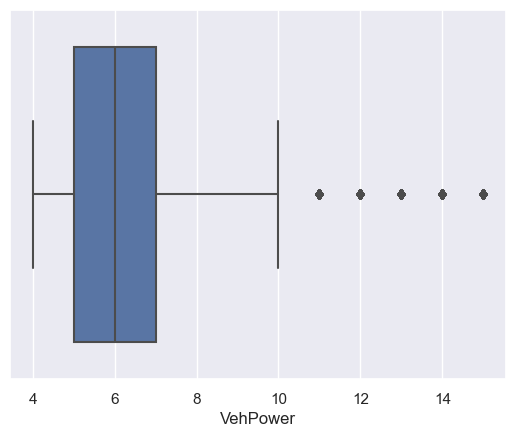

In [5]:
sns.boxplot(x=dfM['VehPower'])

<AxesSubplot:xlabel='VehAge'>

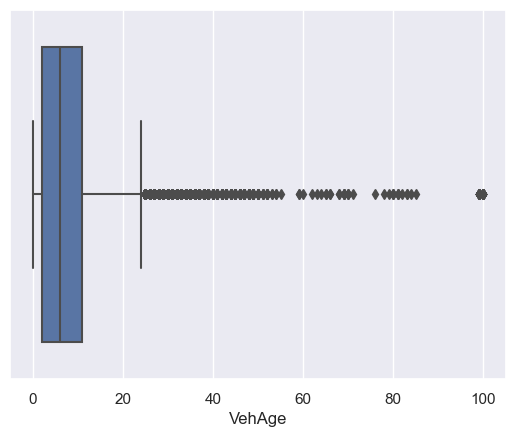

In [237]:
sns.boxplot(x=dfM['VehAge'])

<AxesSubplot:xlabel='DrivAge'>

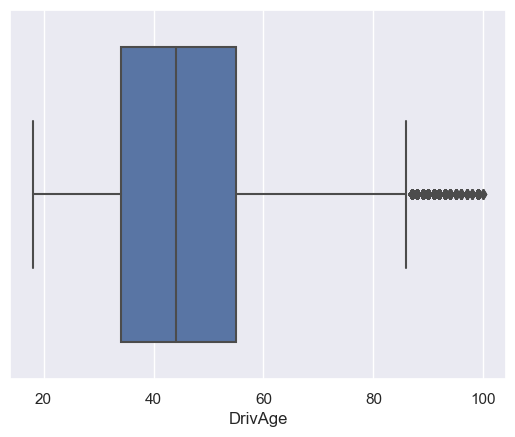

In [238]:
sns.boxplot(x=dfM['DrivAge'])

<AxesSubplot:xlabel='BonusMalus'>

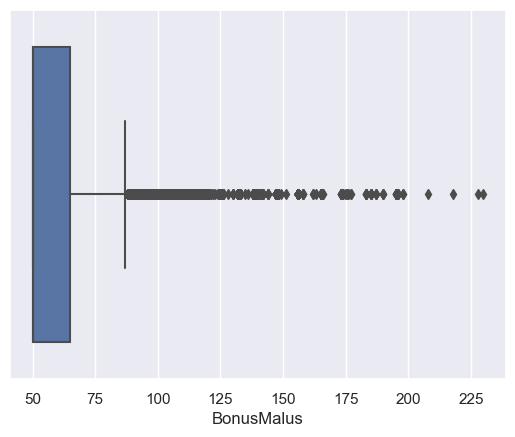

In [239]:
sns.boxplot(x=dfM['BonusMalus'])

<AxesSubplot:xlabel='Density'>

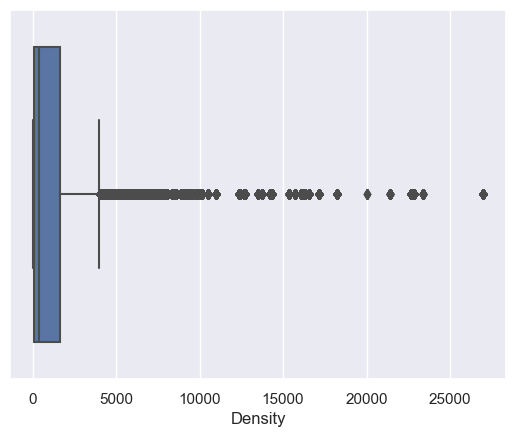

In [240]:
sns.boxplot(x=dfM['Density'])

In [6]:
Q1 = dfM.quantile(0.25)[2:-1]
Q3 = dfM.quantile(0.75)[2:-1]
IQR = Q3 - Q1
print(IQR)

VehPower         2.0
VehAge           9.0
DrivAge         21.0
BonusMalus      15.0
Density       1566.0
dtype: float64


In [7]:
# Delete Outliers
columnsQ = list(IQR.index.values)
print(columnsQ)
df = dfM[~((dfM[columnsQ] < (Q1 - 1.5 * IQR)) |(dfM[columnsQ] > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']


(508943, 12)

In [8]:
groupbyRegion = df.groupby('Region')
groupbyArea = df.groupby('Area')
for region in list(groupbyRegion.groups.keys()):
    print(region,end=' ')
    for name, group in groupbyArea.Region:
        print(name,end = ' ')
        if region in group.unique():
            print('Y ',end='')
        else:
            print('N ',end='')
    print()

'R11' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R21' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R22' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R23' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R24' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R25' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R26' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R31' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R41' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R42' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R43' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R52' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R53' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R54' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R72' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R73' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R74' 'A' Y 'B' Y 'C' Y 'D' Y 'E' N 
'R82' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R83' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R91' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R93' 'A' Y 'B' Y 'C' Y 'D' Y 'E' Y 
'R94' 'A' Y 'B' Y 'C' Y 'D' Y 'E' N 


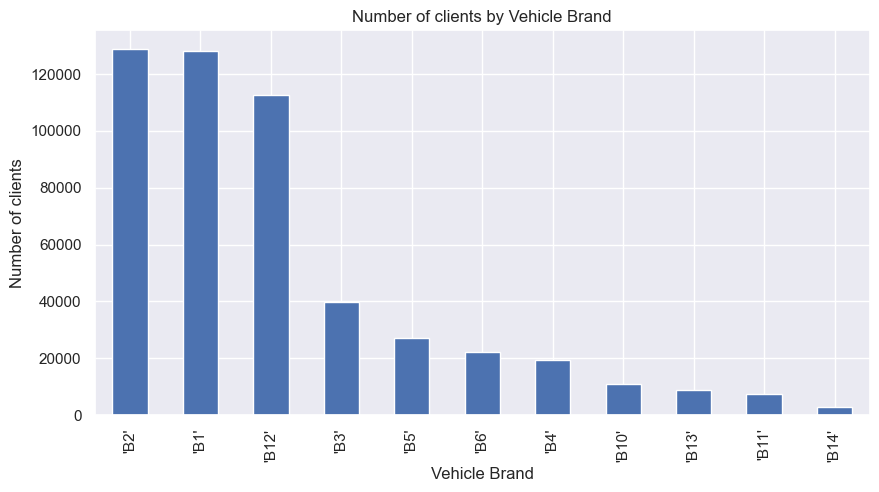

In [244]:
df.VehBrand.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Number of clients by Vehicle Brand")
plt.ylabel('Number of clients')
plt.xlabel('Vehicle Brand');

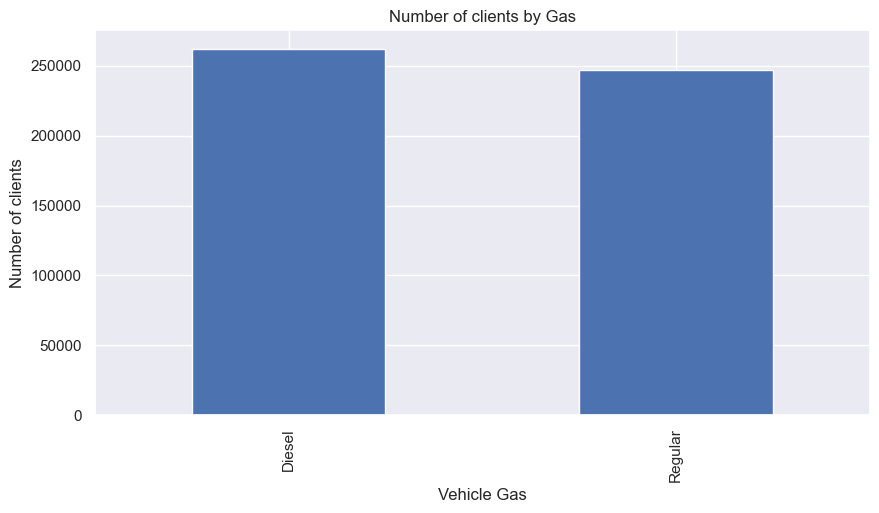

In [245]:
df.VehGas.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Number of clients by Gas")
plt.ylabel('Number of clients')
plt.xlabel('Vehicle Gas');

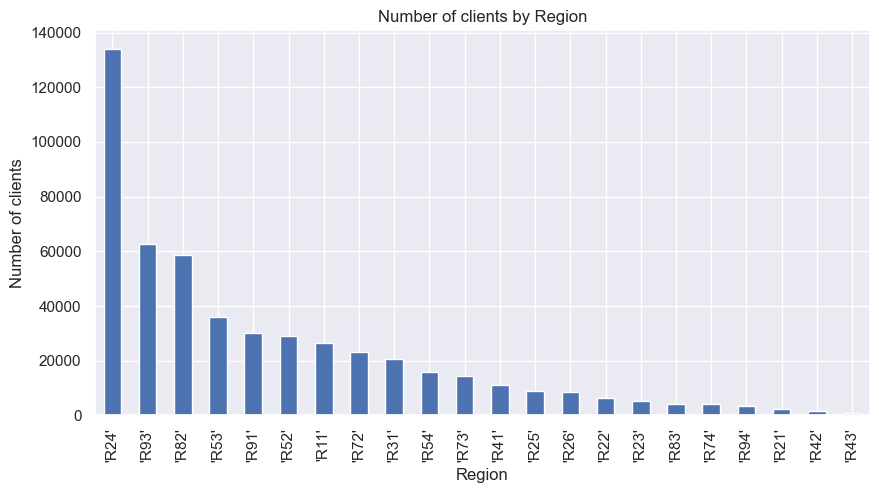

In [246]:
df.Region.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Number of clients by Region")
plt.ylabel('Number of clients')
plt.xlabel('Region');

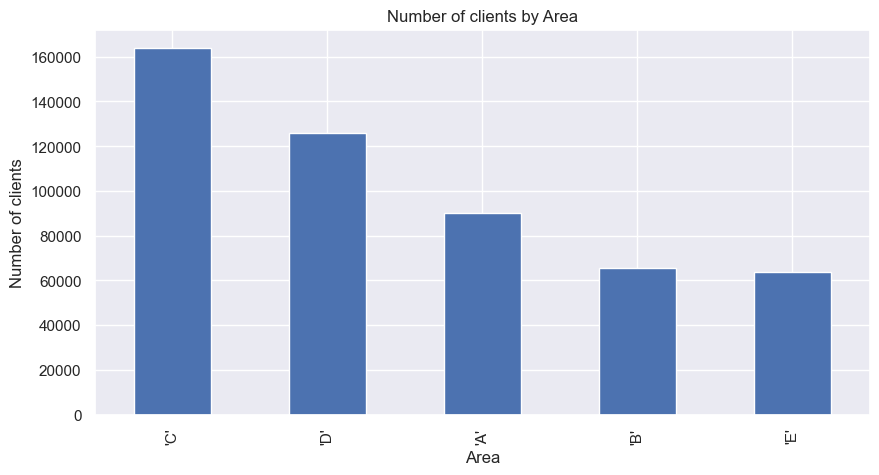

In [247]:
df.Area.value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Number of clients by Area")
plt.ylabel('Number of clients')
plt.xlabel('Area');

0.0     491722
1.0      16416
2.0        765
3.0         30
4.0          3
11.0         2
6.0          1
8.0          1
16.0         1
9.0          1
5.0          1
Name: ClaimNb, dtype: int64


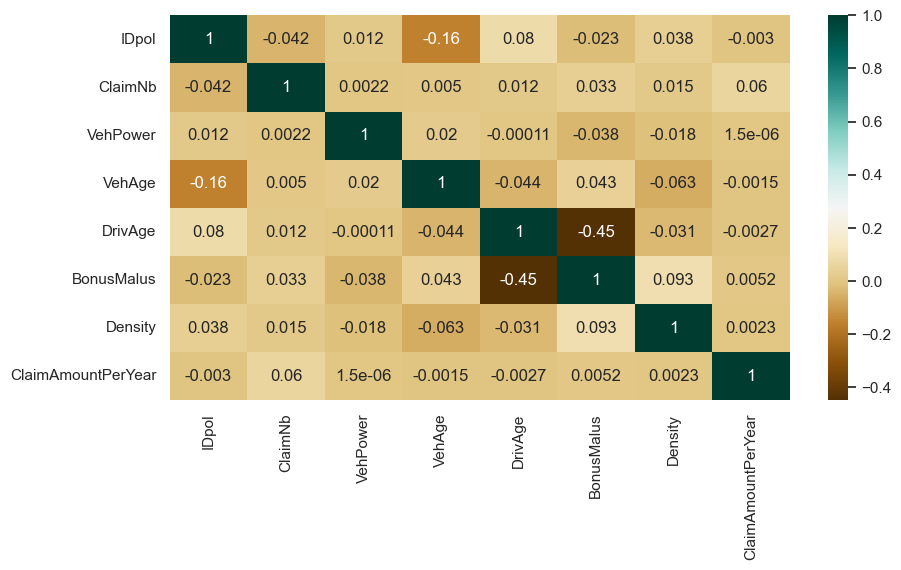

In [248]:
plt.figure(figsize=(10,5))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
print(df.ClaimNb.value_counts())

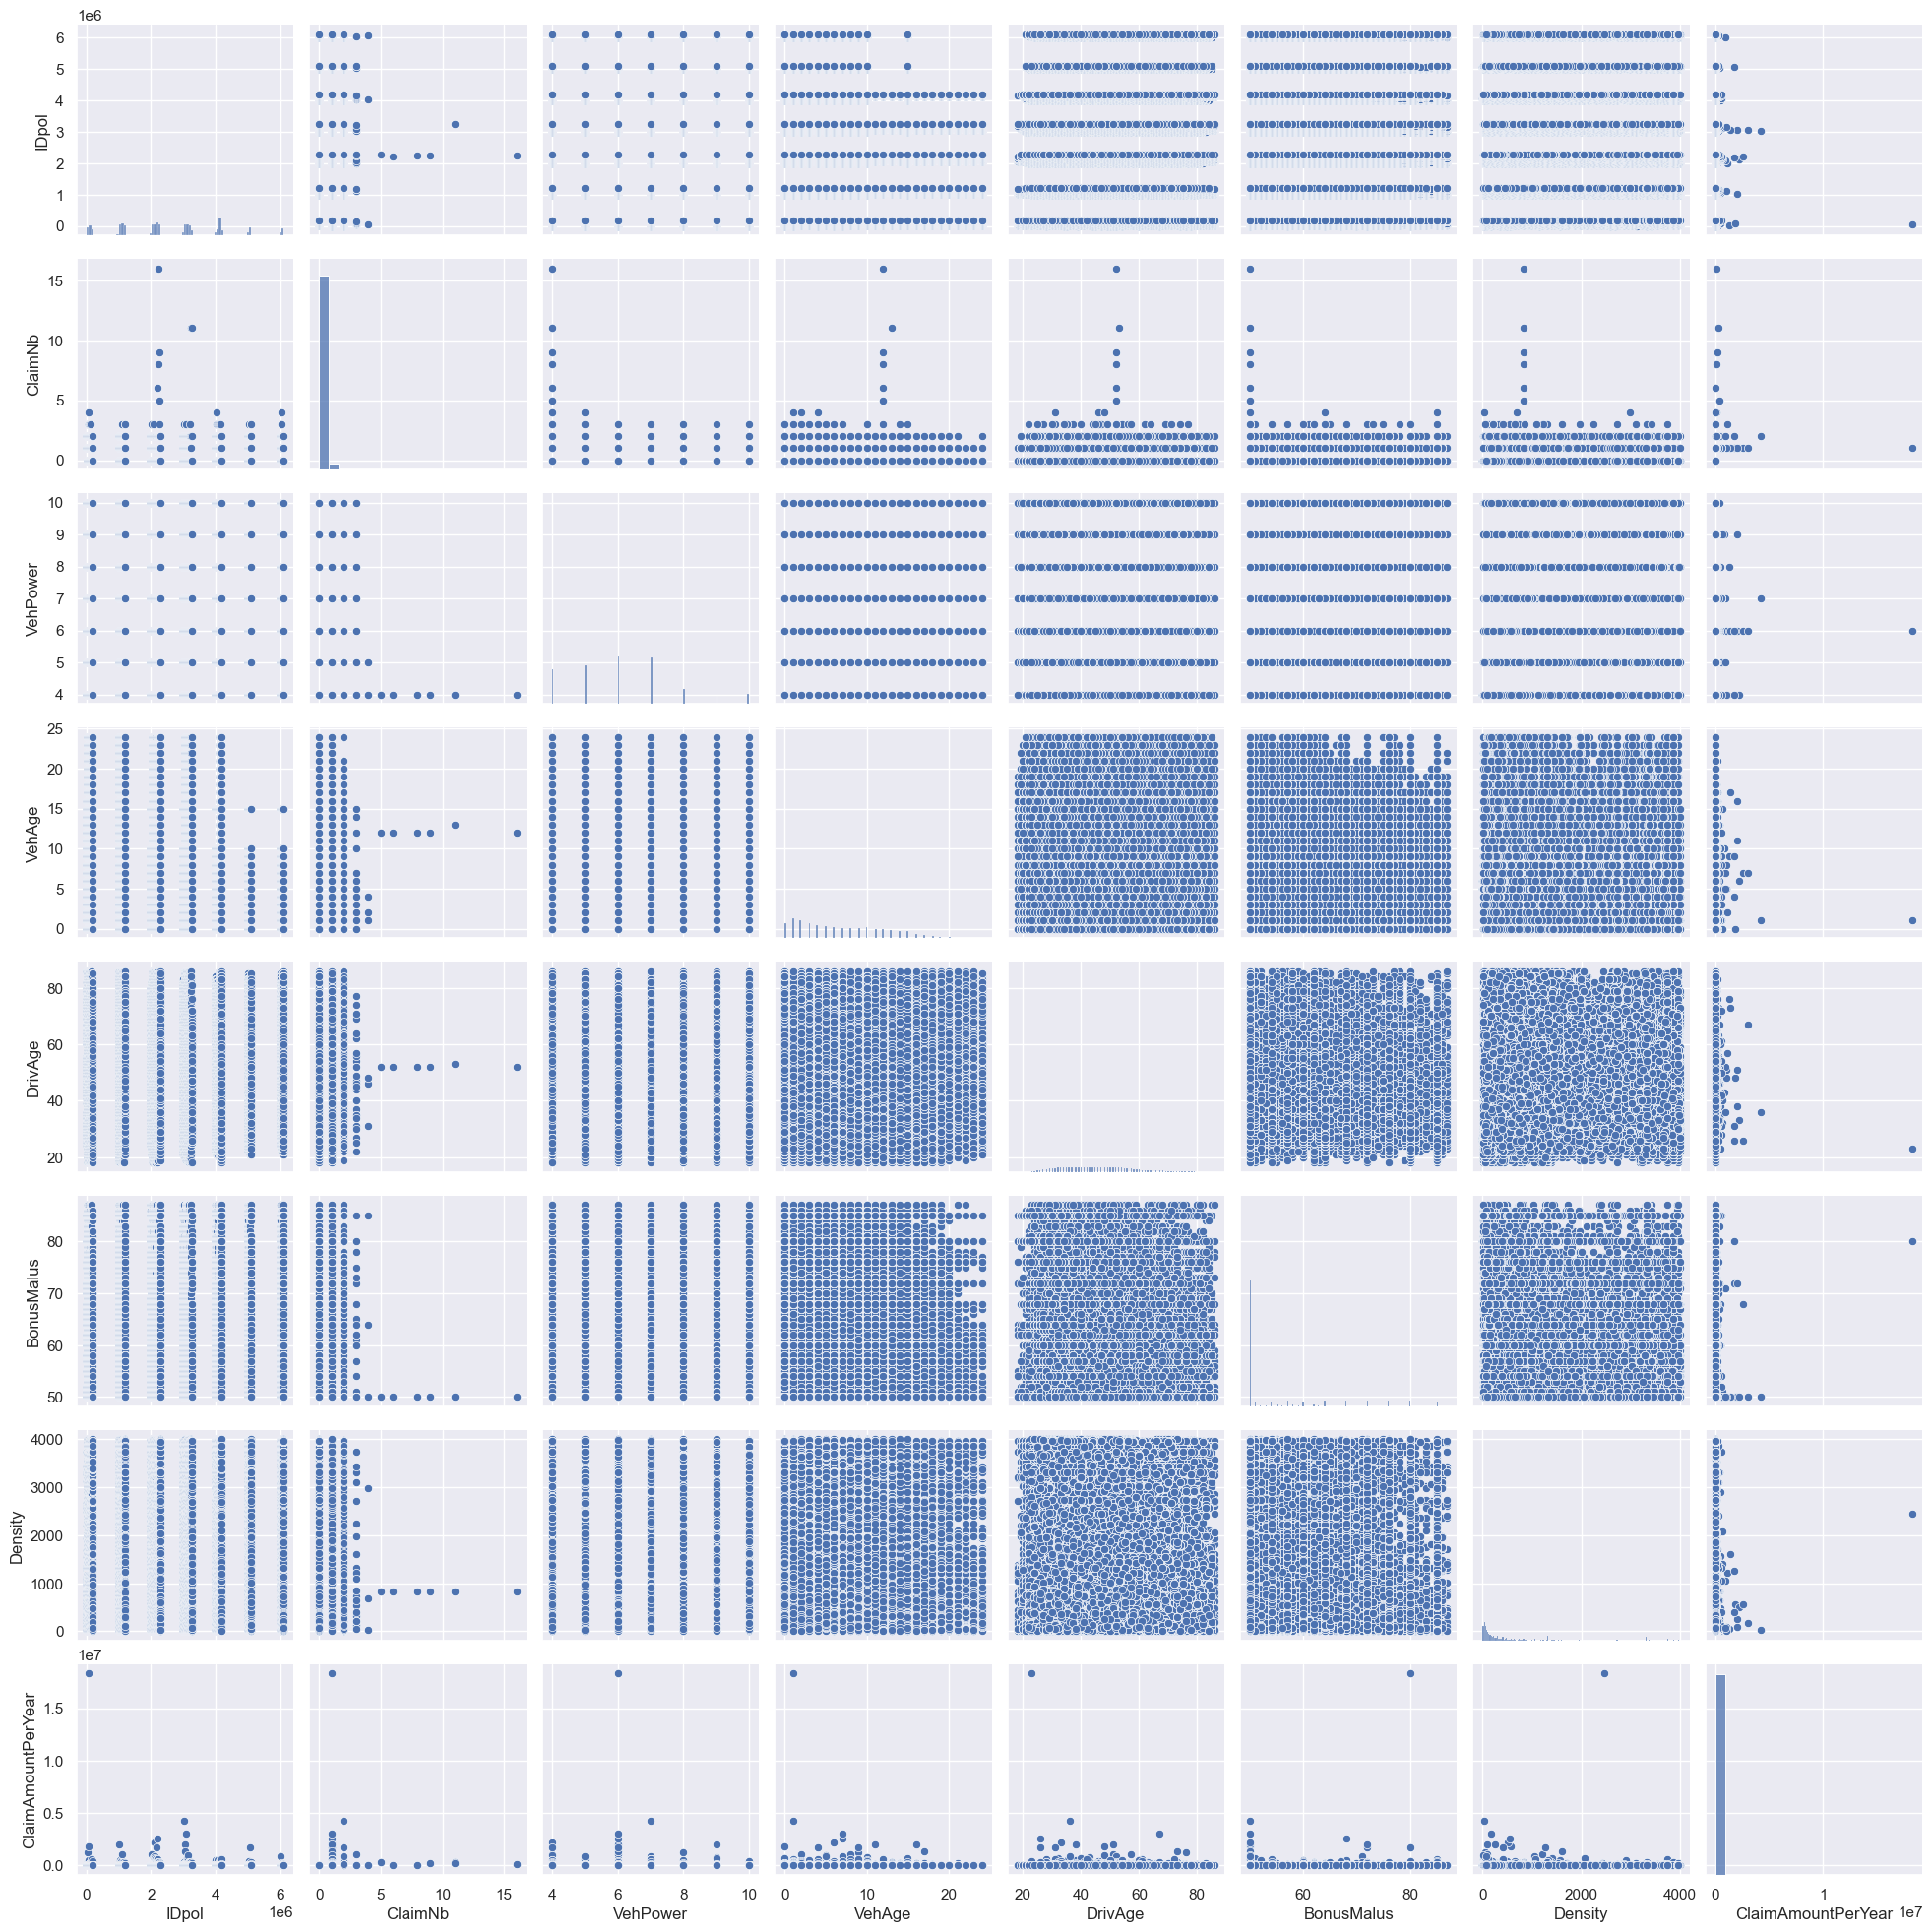

In [11]:
sns.pairplot(df)

### Feature Engineering

In [9]:
# one-hot encoding for Area, VehBrand, VehGas, Region
dftr = pd.get_dummies(df,columns=['Area','VehBrand','VehGas','Region'])
dftr.head(5)

,IDpol,ClaimNb,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmountPerYear,Area_'A',Area_'B',...,Region_'R53',Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94'
4,463.0,1.0,5.0,0.0,45.0,50.0,12.0,12860.225806,1,0,...,0,0,0,1,0,0,0,0,0,0
5,606.0,1.0,10.0,6.0,54.0,50.0,583.0,2190.642857,0,0,...,0,0,0,0,0,0,0,0,1,0
6,622.0,1.0,5.0,0.0,34.0,64.0,1565.0,1863.960000,0,0,...,0,0,0,0,0,0,0,0,0,0
7,811.0,1.0,5.0,0.0,44.0,50.0,3317.0,1278.921053,0,0,...,0,0,0,0,0,0,0,0,1,0
9,975.0,1.0,9.0,0.0,60.0,50.0,570.0,873.164384,0,0,...,0,0,0,0,0,0,0,0,1,0


In [96]:
# Extracting dependent and independant variables
X = dftr.drop(columns=['ClaimAmountPerYear'])
y = dftr['ClaimAmountPerYear']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)

# Create the scaler object with a specified range
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
scaler.fit(X_train)

# Transform both the training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(type(y_test))


<class 'pandas.core.series.Series'>


In [97]:
features = list(X.columns)

# Convert back to dataframes
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

In [99]:
import mlflow
ExperimentName="Pure Premium Estimation"
x=mlflow.get_experiment_by_name(ExperimentName)
if None == x:
  experiment_id = mlflow.create_experiment(ExperimentName)
else:
  experiment_id=x.experiment_id

def score_model_metrics(df_test, X_test, estimator):
  print('probably before error')
  y_pred = estimator.predict(X_test)
  print('probably AFTER error')
  return (
            round(
              mean_absolute_error(
              df_test, y_pred),3
            ),
            round(
            mean_squared_error(
                df_test, y_pred),3)
          )
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)
    y_true=y_true.astype(float)
    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, \
           cumulated_claim_amount,\
           1 - 2 * auc(cumulated_samples, cumulated_claim_amount)

In [106]:
### Modellvergleich